# Computing the Augstin Information via Riemannian Gradient Descent

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

exp = np.exp
log = np.log

# Modules

In [2]:
def get_objective(a, w, alpha=0):
    """ the objective function of the problem of Computing the Augustin information
    a: the random variable (P_{Y|X})
    w: the weight
    alpha: the order
    """
    def objective(x):
        return (1/(alpha-1))*sum(w * np.log(np.dot(a**alpha, x**(1-alpha))))
        # return (1/(alpha-1))*sum([wi*log(dot(ai**alpha, x**(1-alpha))) for (wi, ai) in zip(w, a)])
    return objective

## maps
def exp_map(x, v, case="vector"):
    """exponential map"""
    if case == "vector":
        return x*np.exp(v/x)
    
def log_map(x, y, case="vector"):
    """logarithmic map"""
    if case == "vector":
        return x*np.log(y/x)

## Algorithms

In [3]:
def gradient(x, a, w, alpha=0):
    """the gradient of the objective function at x
    """
    if alpha == 0:
        a = np.array(a)
        # return -sum([wi*ai/np.dot(ai, x) for (ai, wi) in zip(a, w)])
    elif alpha != 0:
        a = np.array(a)**alpha
        # return -sum([wi*ai**alpha*x**(-alpha)/np.dot(ai**alpha, x**(1-alpha)) for (ai, wi) in zip(a, w)])

    # make the computation faster (not use for-loop)
    return -sum(( ( w / np.dot(a, x**(1-alpha)) ) * (a * x**(-alpha)).T ).T)

def get_FP(a, w, alpha=0):
    """get the fixed-point iteration proposed by Nakiboğlu"""
    def FP(x):
        return -x*gradient(x, a, w, alpha)
    return FP

def get_RGD(a, w, alpha=0):
    def RGD(x):
        D = len(x)  # parameter dimension
        grad = x*x*(np.ones(D)+gradient(x, a, w, alpha))
        return exp_map(x, -1/(abs(1-alpha)+1)*grad, "vector")
    return RGD

def get_entropic_mirror_descent(a, w, alpha=0):
    """a gradient-based method, 
    it would be used by the methods proposed by Li and Cevher and You et al.
    """
    def entropic_mirror_descent(x, eta):
        x_next = x*exp(-eta*gradient(x, a, w, alpha))
        return x_next/sum(x_next)
    return entropic_mirror_descent

def polyak_step_size(x, function_values, gradient_x, delta_t, objective_function, iteration_rule, \
                     delta=1e-14, beta=0.99, gamma=1.25, c=5):
    """iterate as the method proposed by You et al.
    [input]
    x               : the current iterate
    function_values : previous function values
    gradient_x      : the gradient of the obj. func. at the current iterate
    delta_t         : a parameter that depends on t (the current iteration number)
    delta ~ c       : parameters of this method (see You et al.)
    
    [output]
    x_next          : the next iterate
    delta_t_next    : the updated delta_t
    """
    min_f_tilde = min(function_values) - delta_t
    gradient_dual_norm = max(gradient_x)
    
    # Polyak step size
    eta_t = (function_values[-1]-min_f_tilde)/(c*gradient_dual_norm**2)
    
    # entropic mirror descent
    x_next = iteration_rule(x, eta_t)
    
    # updating step size
    if objective_function(x_next) <= min_f_tilde:
        delta_t_next = gamma*delta_t
    else:
        delta_t_next = max(beta*delta_t, delta)
        
    return x_next, delta_t_next

## Pack

In [4]:
def iterating(objective_function, initialization, iteration_rule, T, plot=False, normalization=True):
    """use the given iteration rule (could be the fixed-point iteration or RGD) to run T iterations
    [input]
    objective_function  : the objective function
    initialization      : the initialization
    iteration_rule      : the iteration rule
    T                   : the number of iteration
    plot                : whether to plot the optimization error
    normalization       : whether to normalize iterates when evaluating the function value
    
    [output]
    function_values [list] : function values of all T iteration (inculding the initialization)
    iterates        [list] : all iterates
    elapsed_time    [list] : elapsed_time[t] is the elapsed time after t itertations
    """
    x = initialization
    
    function_values = [objective_function(x)]
    iterates = [x]
    elapsed_time = [0]
    start_time = time.time()
    
    for _ in range(T):
        # get the next iterate
        x = iteration_rule(x)
        iterates.append(x)
        
        # evaluate the function value
        if normalization:
            function_values.append(objective_function(x/sum(x)))
        else:
            function_values.append(objective_function(x))
        
        # running time
        elapsed_time.append(time.time() - start_time)
        
    if plot:
        plotting(function_values, elapsed_time)
        
    return function_values, iterates, elapsed_time

def iterating_polyak(objective_function, initialization, iteration_rule, T, plot=False, normalization=True,\
                    delta=1e-5, beta=0.99, gamma=1.25, c=5):
    """use the method proposed by You et al. to run T iterations
    [input]
    same as the input of the function "iterating"
    delta ~ c : parameters of the method proposed by You et al. (see You et al.)
    
    [output]
    same as the ouptut of the function "iterating"
    """
    x = initialization
    
    function_values = [objective_function(x)]
    iterates = [x]
    elapsed_time = [0]
    start_time = time.time()
    
    delta_t = 1
    delta_ts = [delta_t]
    
    for _ in range(T):
        gradient_x = gradient(x, a, w, alpha)  # gradient at x
        
        # get the next iterate
        x, delta_t = polyak_step_size(x, function_values, gradient_x, delta_t, objective_function, iteration_rule,
                                      delta=delta, beta=beta, gamma=gamma, c=c)
        iterates.append(x)
        delta_ts.append(delta_t)
        
        # evaluate the function value
        if normalization:
            function_values.append(objective_function(x/sum(x)))
        else:
            function_values.append(objective_function(x))
            
        # running time
        elapsed_time.append(time.time() - start_time)
        
    if plot:
        plotting(function_values, elapsed_time)

    return function_values, iterates, elapsed_time

def iterating_armijo(objective_function, initialization, iteration_rule, T, plot=False, normalization=True,\
                    a_bar=0.4, r=0.7, tau=0.7):
    """use the method proposed by Li and Cevher to run T iterations
    [input]
    same as the input of the function "iterating"
    a_bar, r, tau : parameters of the method proposed by Li and Cevher (see You et al.)
    
    [output]
    same as the ouptut of the function "iterating"
    """
    x = initialization
    
    function_values = [objective_function(x)]
    iterates = [x]
    elapsed_time = [0]
    start_time = time.time()
    
    for _ in range(T):
        gradient_x = gradient(x, a, w, alpha)  # gradient at x
        
        # line search
        current_a = a_bar
        x_next = iteration_rule(x, current_a)
        while objective_function(x_next) > objective_function(x) + tau*np.dot(gradient_x, x_next - x):
            current_a = r*current_a
            x_next = iteration_rule(x, current_a)
        
        # show the iteration number to prevent getting stuck halfway when it has already achieve the optimal point.
        print(_, end="")  
        
        # get the next iterate
        x = iteration_rule(x, current_a)
        iterates.append(x)
        
        # evaluate the function value
        if normalization:
            function_values.append(objective_function(x/sum(x)))
        else:
            function_values.append(objective_function(x))
        
        # running time
        elapsed_time.append(time.time() - start_time)
    
        
    if plot:
        plotting(function_values, elapsed_time)

    return function_values, iterates, elapsed_time

## Plotting

In [5]:
def plotting(function_values, elapsed_time):
    f_star = function_values[-1]
    f_star = min(function_values)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot([ft-f_star for ft in function_values[:-1]])
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel("Approx. opt. error (log scale)")
    axs[0].set_yscale("log")

    axs[1].plot(elapsed_time, [ft-f_star for ft in function_values])
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Elapsed time (s)")
    axs[1].set_ylabel("Approx. opt. error (log scale)")
    
def plot_approximation_error(all_alg, f_star=False, T=-1, bottom=None, top=None, left=None, right=None):
    if not f_star:
        f_star = min([min(function_values[alg]) for alg in all_alg])

    label_name = {"FP": "Fixed-point", "RGD": "RGD", "Polyak": "You et al.", "Armijo": "Li and Cevher",}
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    for alg in all_alg:
        axs[0].plot([ft-f_star for ft in function_values[alg][:T]], label=label_name[alg])
        axs[1].plot(elapsed_time[alg], [ft-f_star for ft in function_values[alg]], label=label_name[alg])

    # fig.suptitle("(relaxation) Augustin Information (alpha={}, D={}, N={})".format(alpha, D, N))

    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel("Approx. opt. error")
    axs[0].set_yscale("log")
    axs[0].set_ylim(bottom=bottom, top=top)
    axs[0].legend()
    axs[0].grid(which="both")

    axs[1].set_xlabel("Elapsed time (s)")
    axs[1].set_ylabel("Approx. opt. error")
    axs[1].set_yscale("log")
    axs[1].set_ylim(bottom=bottom, top=top)
    axs[1].set_xlim(left=left, right=right)
    axs[1].legend()
    axs[1].grid(which="both")

In [6]:
algorithms = ["FP", "RGD", "Armijo", "Polyak"]

function_values, iterates, elapsed_time = {}, {}, {}
for i in algorithms:
    function_values[i] = []
    iterates[i] = []        
    elapsed_time[i] = []

# Computing the Augustin Information

In [12]:
# D: parameter dimension
# N: support cardinality
# T: number of iterations
# a: random variable in the probability simplex
# w: weights

D, N = 2**4, 2**14
T = 20

a = []
for i in range(N):
    a.append(np.random.exponential(scale=1.0, size=D))
    a[i] /= sum(a[i])
a = np.array(a)
w = np.random.rand(N)
w /= sum(w)



## tuned parameters

In [13]:
## setting
alpha = 3
all_alg = ["FP", "RGD", "Armijo", "Polyak"]
objective_function = get_objective(a, w, alpha)

## initialization
initialization = np.ones(D)/D

## iterateing
for alg in all_alg:
    if alg == "FP":
        iteration_rule = get_FP(a, w, alpha)
        result = iterating(objective_function, initialization, iteration_rule, T)
        
    elif alg == "RGD":
        iteration_rule = get_RGD(a, w, alpha)
        result = iterating(objective_function, initialization, iteration_rule, T)
        
    elif alg == "Armijo":
        iteration_rule = get_entropic_mirror_descent(a, w, alpha)
        result = iterating_armijo(objective_function, initialization, iteration_rule, 20, 
                                  a_bar=0.4, r=0.7, tau=0.5)        
        
    elif alg == "Polyak":
        iteration_rule = get_entropic_mirror_descent(a, w, alpha)
        result = iterating_polyak(objective_function, initialization, iteration_rule, T,
                                 delta=1e-5, beta=0.99, gamma=1.25, c=10)
    
    function_values[alg], iterates[alg], elapsed_time[alg] = result
    
f_star = min(function_values['Armijo'])

012345678910111213141516171819

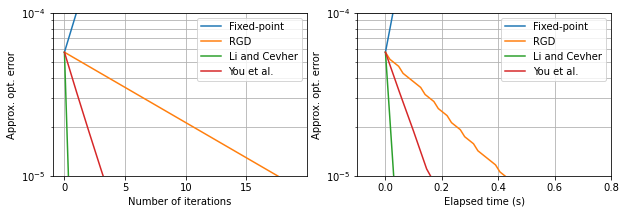

In [14]:
plot_approximation_error(all_alg, f_star=f_star, T=T, top=1e-4, bottom=1e-5, left=-0.1, right=0.8)
# plot_approximation_error(all_alg, f_star=f_star, T=T, top=1e-3)


## bad parameters

In [17]:
## setting
alpha = 3
all_alg = ["FP", "RGD", "Armijo", "Polyak"]
objective_function = get_objective(a, w, alpha)

## initialization
initialization = np.ones(D)/D

## iterateing
for alg in all_alg:
    if alg == "FP":
        iteration_rule = get_FP(a, w, alpha)
        result = iterating(objective_function, initialization, iteration_rule, T)
        
    elif alg == "RGD":
        iteration_rule = get_RGD(a, w, alpha)
        result = iterating(objective_function, initialization, iteration_rule, T)
        
    elif alg == "Armijo":
        iteration_rule = get_entropic_mirror_descent(a, w, alpha)
        result = iterating_armijo(objective_function, initialization, iteration_rule, T, 
                                  a_bar=0.04, r=0.7, tau=0.5)        
        
    elif alg == "Polyak":
        iteration_rule = get_entropic_mirror_descent(a, w, alpha)
        result = iterating_polyak(objective_function, initialization, iteration_rule, T, 
                                  delta=1e-5, beta=0.99, gamma=1.25, c=100)
    
    function_values[alg], iterates[alg], elapsed_time[alg] = result

012345678910111213141516171819

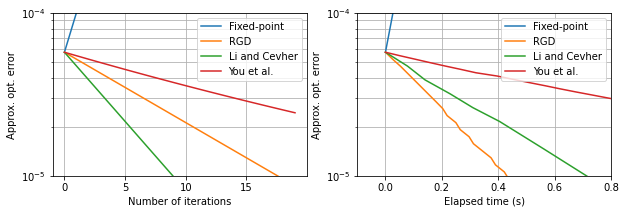

In [18]:
plot_approximation_error(all_alg, f_star=f_star, T=T, top=1e-4, bottom=1e-5, left=-0.1, right=0.8)
# plot_approximation_error(all_alg, f_star=f_star, T=T, top=1e-3)


In [22]:
ff[-1] == function_values['RGD'][-1]

True